In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (20,10)

# home prices into a dataframe

In [11]:
df1 = pd.read_csv("/content/Bengaluru_House_Data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [12]:
df1.shape

(13320, 9)

In [13]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [14]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [15]:
df1['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

In [16]:
# Drop features that are not required to build our model
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(13320, 5)

# Data Cleaning: Handle NA values

In [17]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [18]:
df2.shape

(13320, 5)

In [19]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [20]:
df3.shape

(13246, 5)

# Feature Engineering

In [21]:
# Add new feature(integer) for bhk (Bedrooms Hall Kitchen)
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

<ipython-input-21-6fd97f1757e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [22]:
df3[df3.bhk>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [23]:
df3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [24]:
#Explore total_sqft feature

def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [25]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple

In [26]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [27]:
convert_sqft_to_num("2100 - 2850")

2475.0

In [28]:
convert_sqft_to_num("1056")

1056.0

In [29]:
convert_sqft_to_num("34.46Sq. Meter")

In [30]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)


In [31]:
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [32]:
(2100+2850)/2

2475.0

# Feature Engineering

In [33]:
df5 = df4.copy()

In [34]:
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [35]:
len(df5.location.unique())

1304

In [36]:
df5.location = df5.location.apply(lambda x: x.strip())

location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats


location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [37]:
len(location_stats[location_stats<=10])

1052

In [38]:
len(df5.location.unique())

1293

In [39]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats[location_stats<=10] else x)
len(df5.location.unique())

242

In [40]:

df5.head(20)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


<Axes: xlabel='bhk', ylabel='price_per_sqft'>

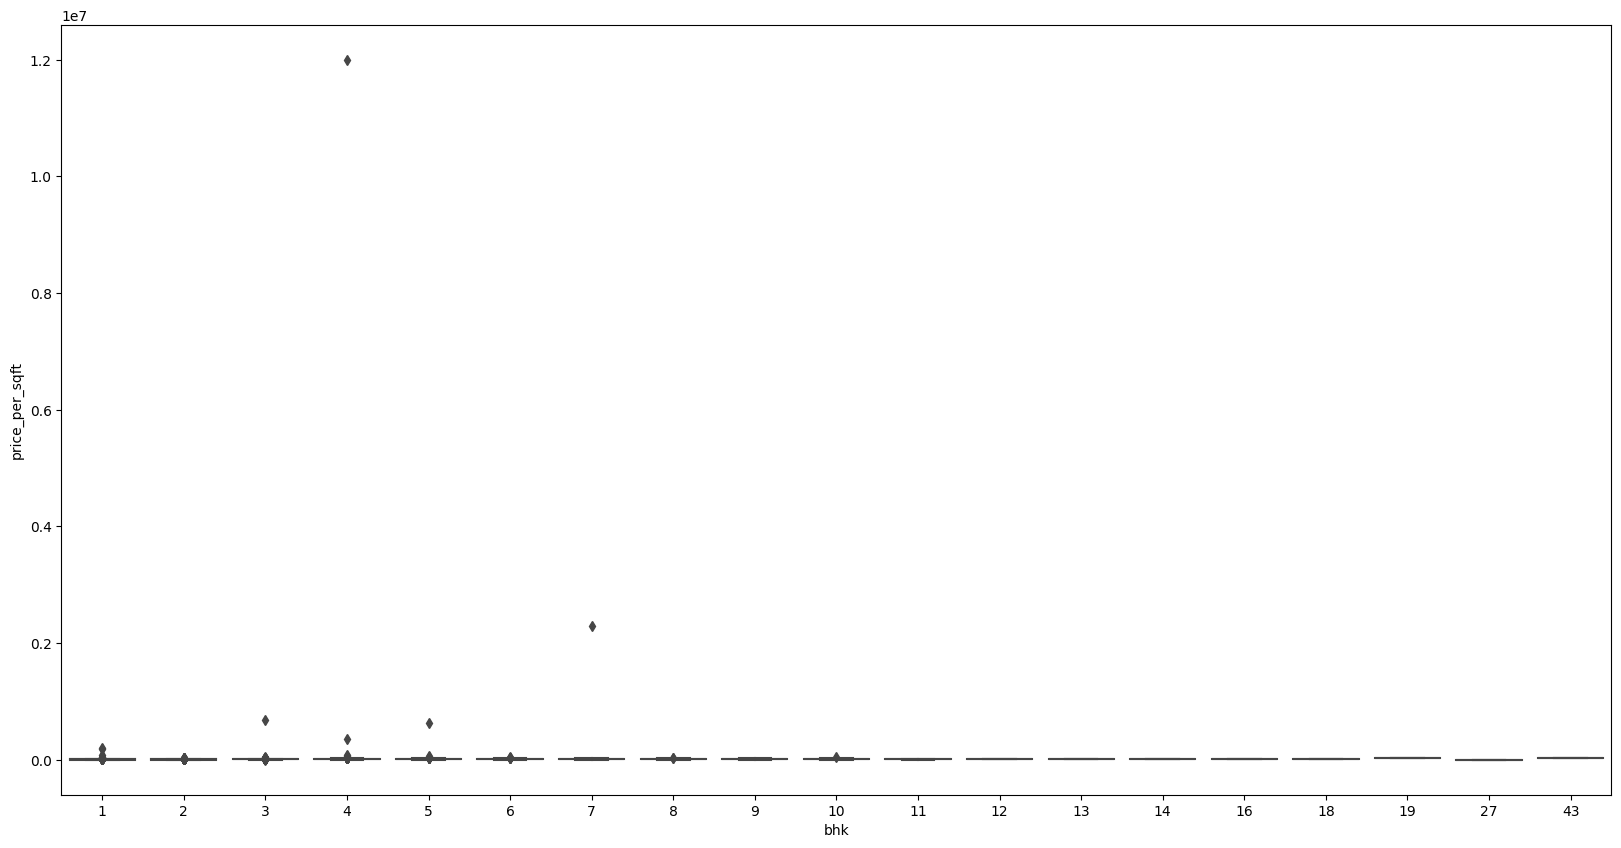

In [41]:
sns.boxplot( data = df5, x = 'bhk', y = 'price_per_sqft')

In [42]:
df5[(df5.price_per_sqft >= 300) & (df5.price_per_sqft <= 20000)].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [43]:
df5.shape

(13246, 7)

In [44]:
df6 = df5[(df5.price_per_sqft >= 300) & (df5.price_per_sqft <= 20000)]
df6.shape

(12963, 7)

<Axes: xlabel='bhk', ylabel='price_per_sqft'>

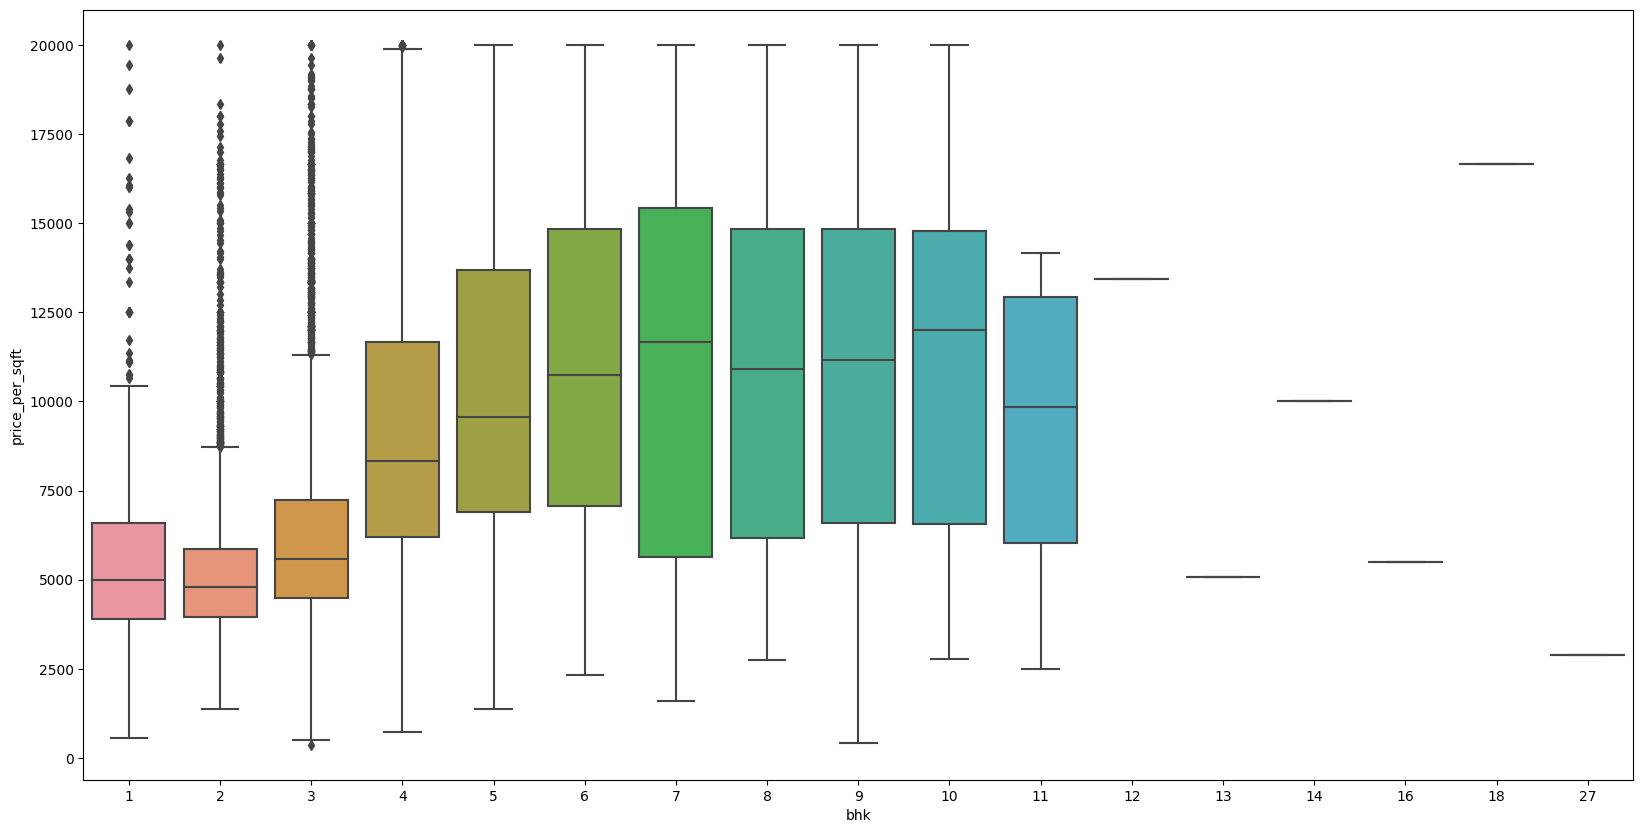

In [45]:
sns.boxplot( data = df6, x = 'bhk', y = 'price_per_sqft')

In [46]:
df6.price_per_sqft.describe()

count    12963.000000
mean      6331.289969
std       3248.126679
min        371.428571
25%       4250.000000
50%       5387.453875
75%       7142.857143
max      20000.000000
Name: price_per_sqft, dtype: float64

In [47]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10147, 7)

<Axes: xlabel='bhk', ylabel='price_per_sqft'>

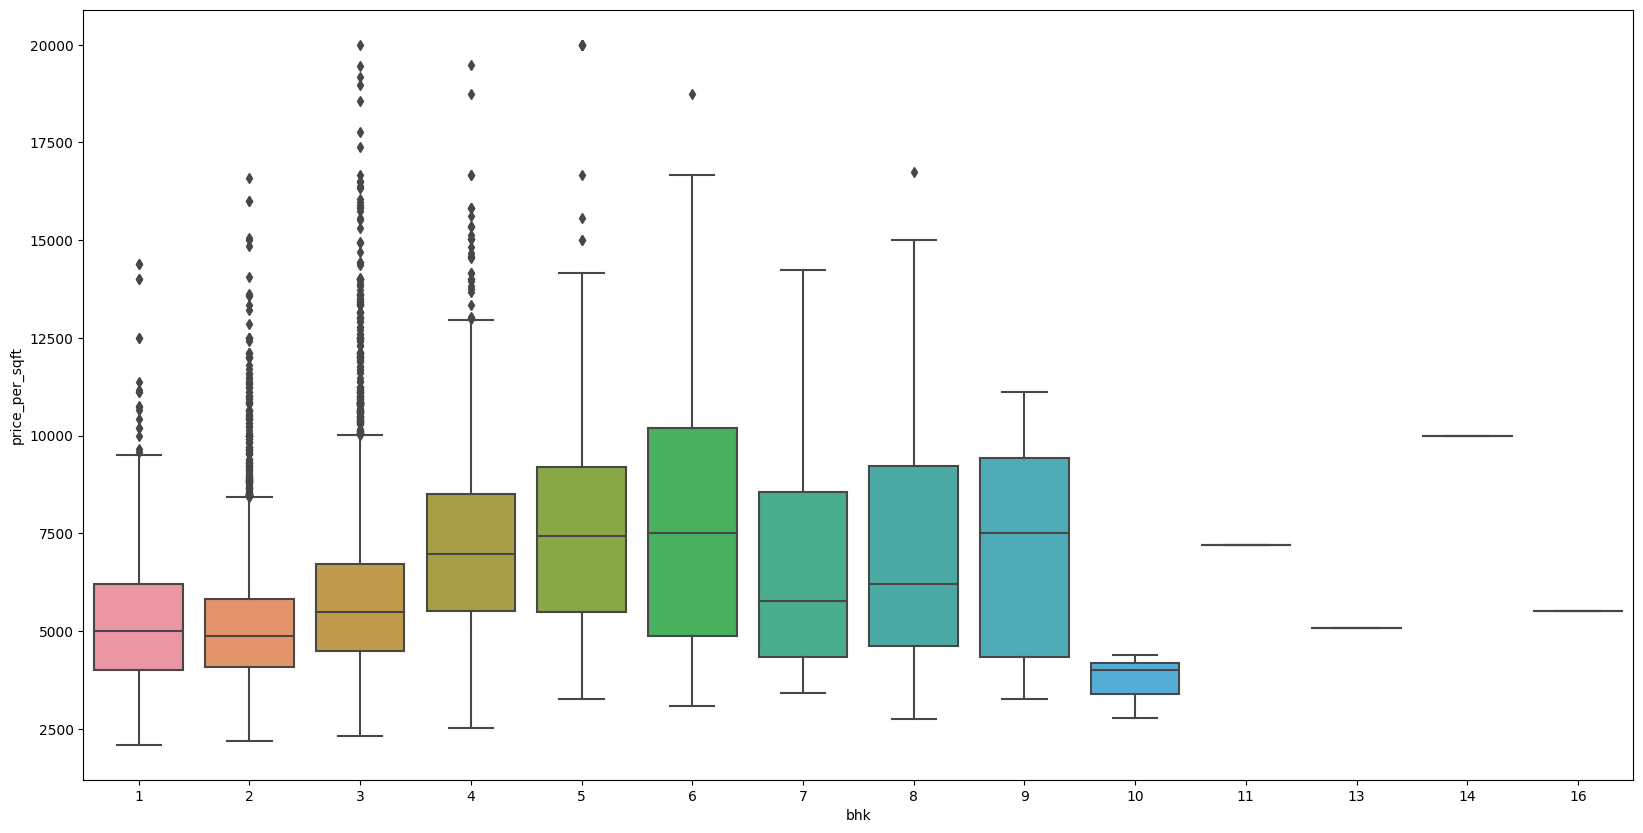

In [48]:
sns.boxplot( data = df7, x = 'bhk', y = 'price_per_sqft')

In [49]:
print(df7.head())

              location       size  total_sqft  bath  price  bhk  \
0  1st Block Jayanagar      4 BHK      2850.0   4.0  428.0    4   
1  1st Block Jayanagar      3 BHK      1630.0   3.0  194.0    3   
2  1st Block Jayanagar      6 BHK      1200.0   6.0  125.0    6   
3  1st Block Jayanagar      3 BHK      1875.0   2.0  235.0    3   
4  1st Block Jayanagar  7 Bedroom       930.0   4.0   85.0    7   

   price_per_sqft  
0    15017.543860  
1    11901.840491  
2    10416.666667  
3    12533.333333  
4     9139.784946  


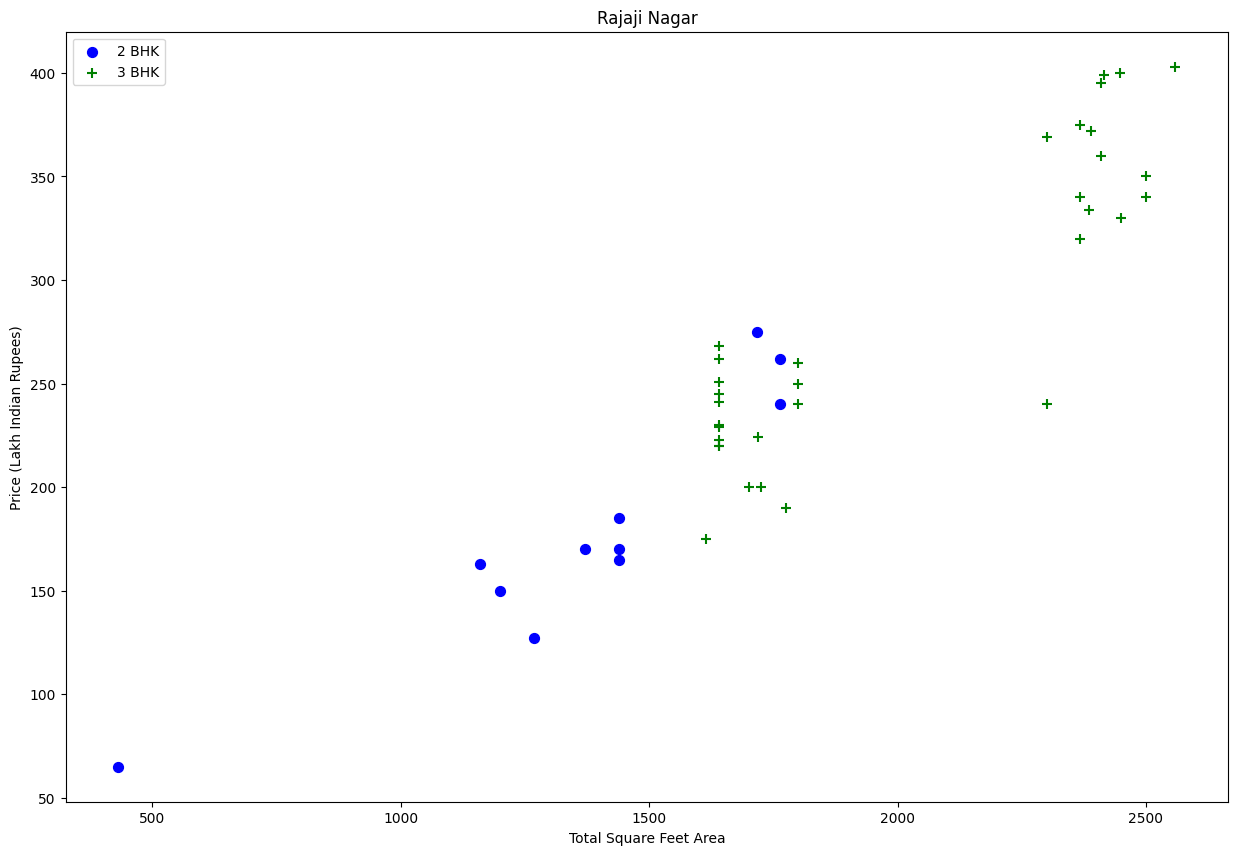

In [50]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()

plot_scatter_chart(df7,"Rajaji Nagar")


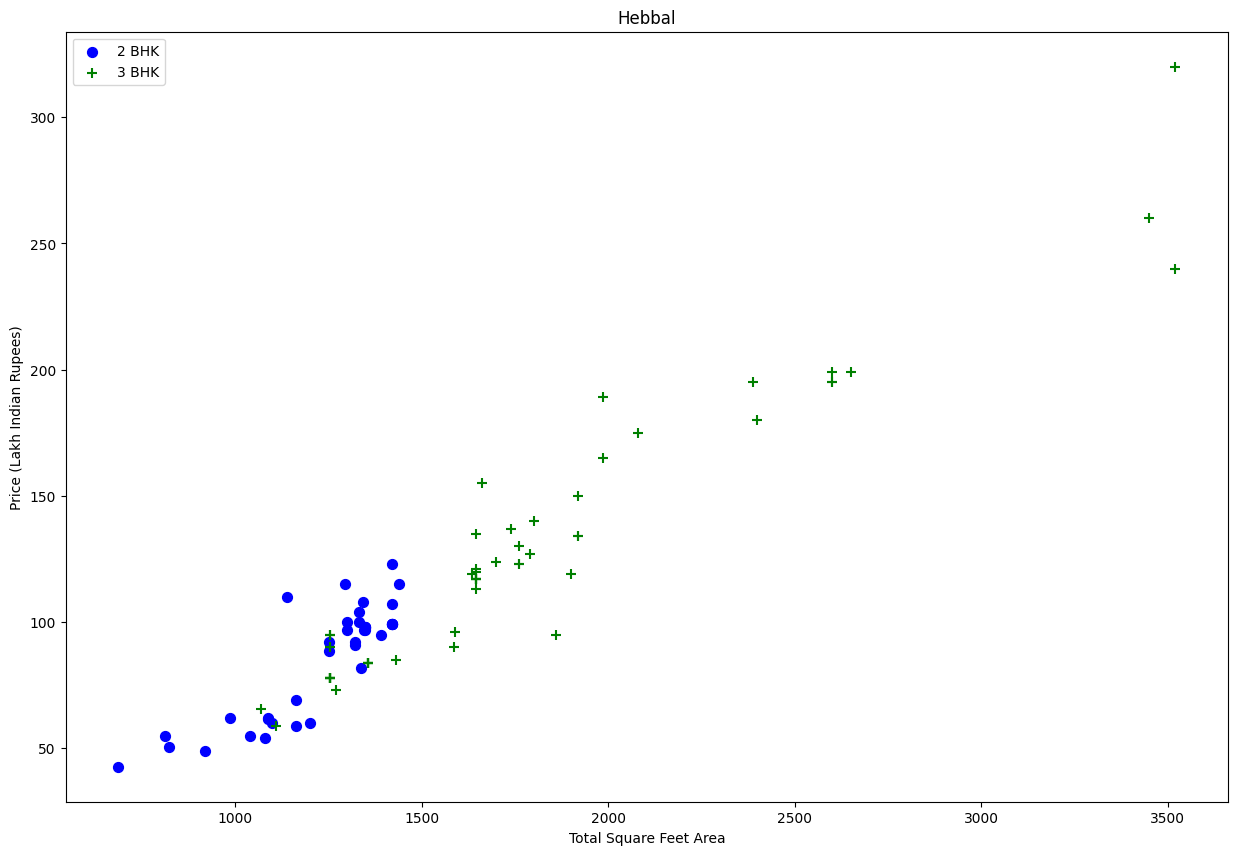

In [51]:
plot_scatter_chart(df7,"Hebbal")


In [52]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape


(7243, 7)

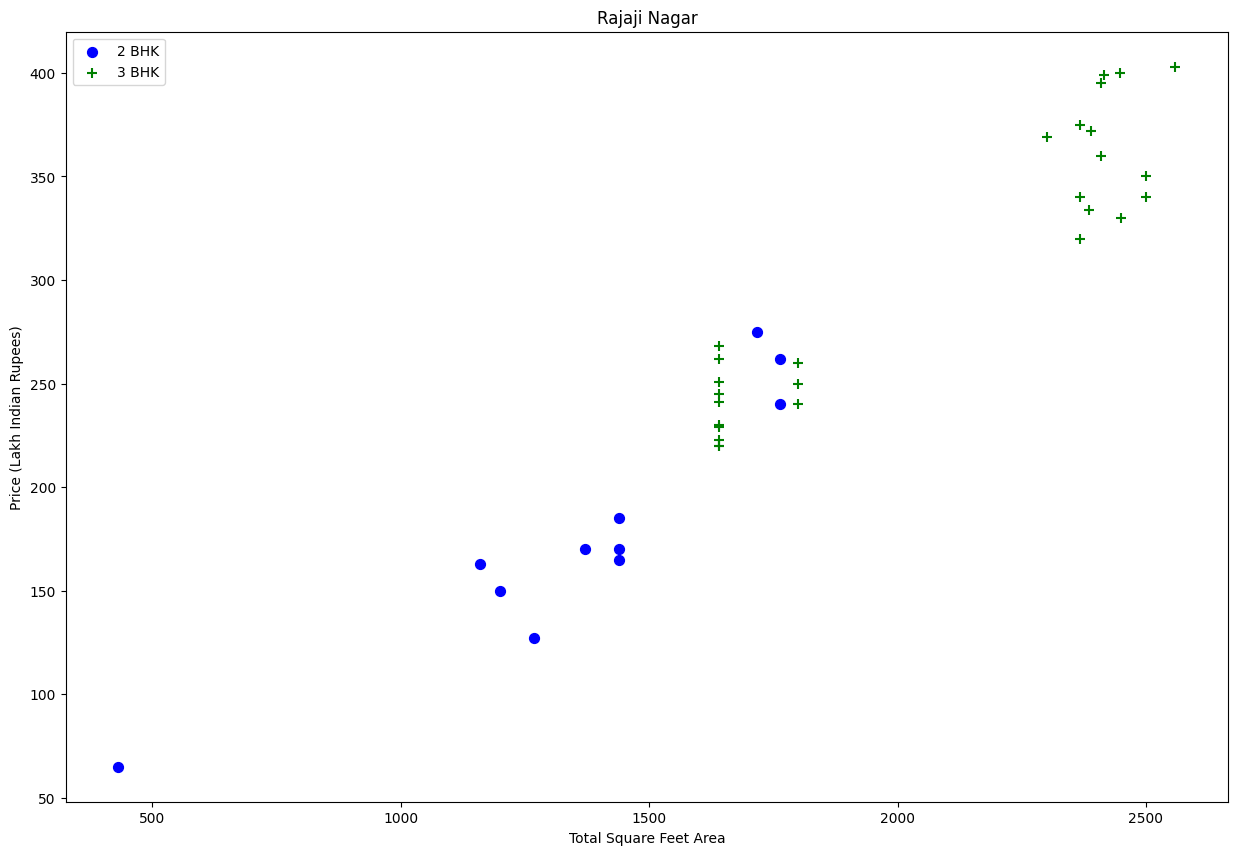

In [53]:
plot_scatter_chart(df8,"Rajaji Nagar")

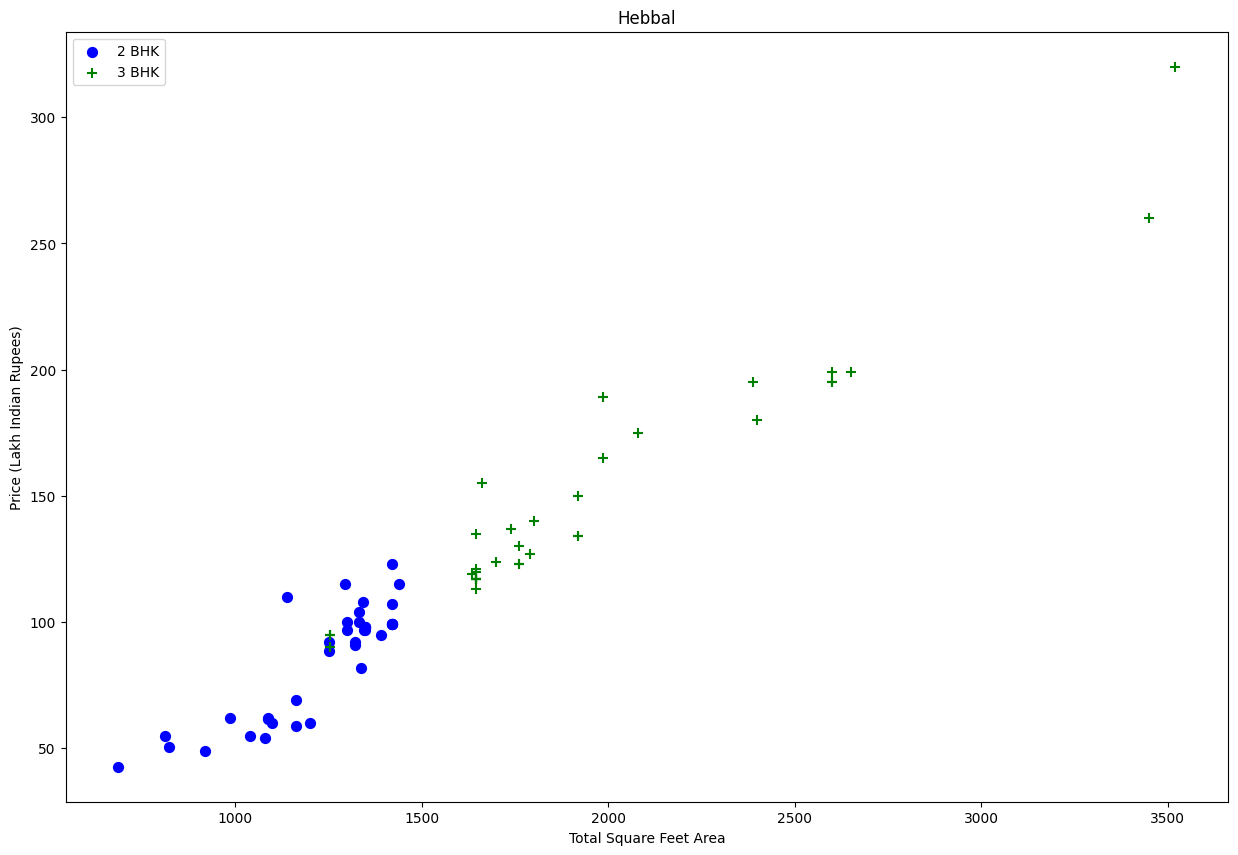

In [54]:
plot_scatter_chart(df8,"Hebbal")

<Axes: xlabel='bhk', ylabel='price_per_sqft'>

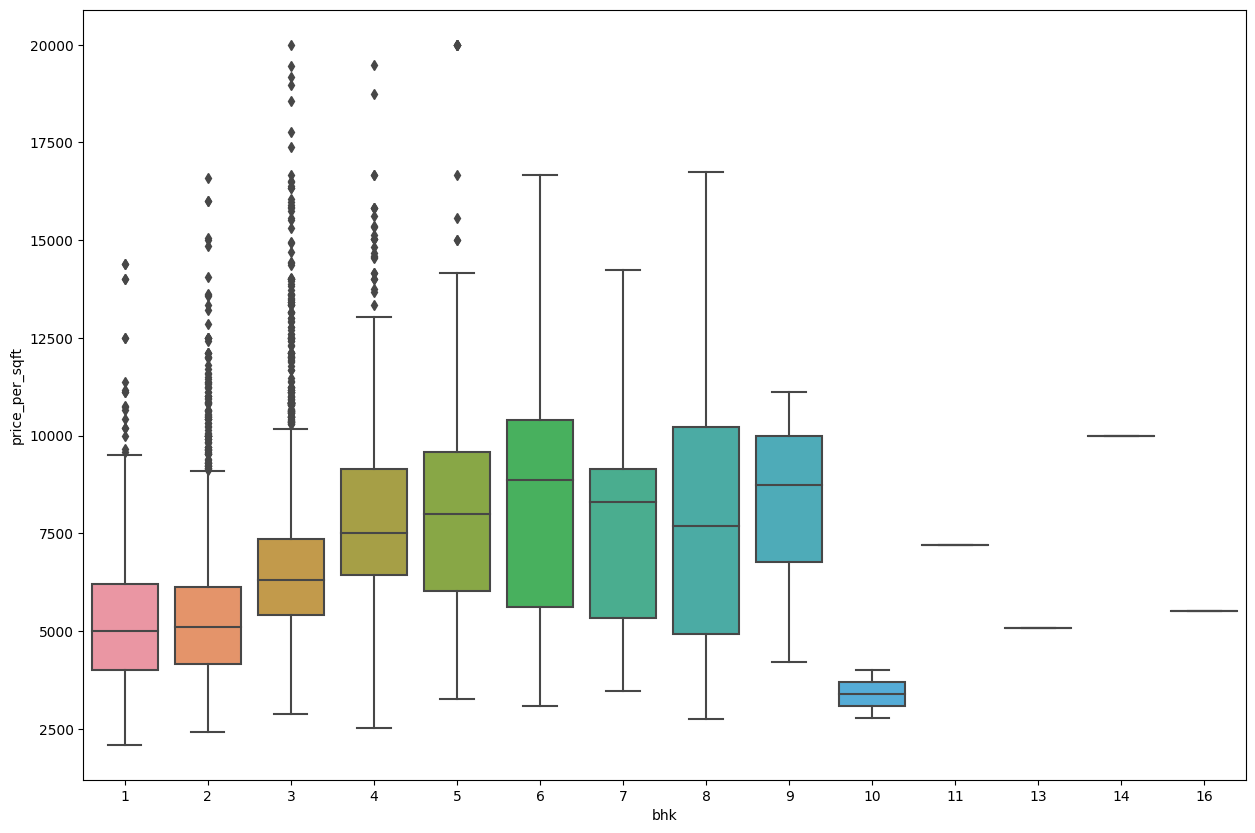

In [55]:
sns.boxplot( data = df8, x = 'bhk', y = 'price_per_sqft')

Text(0, 0.5, 'Count')

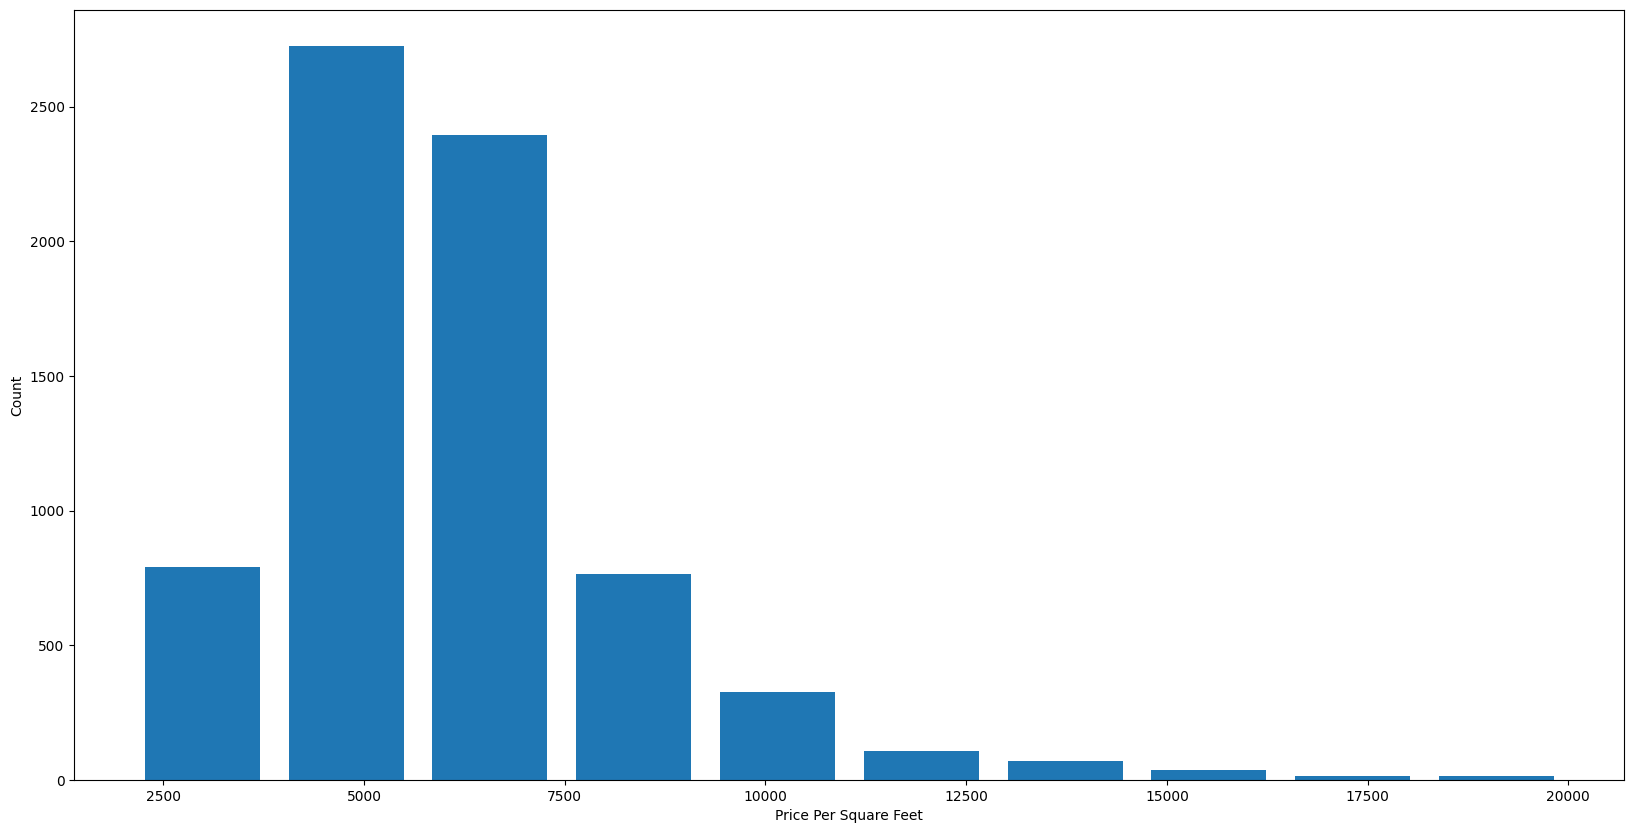

In [56]:
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

In [57]:
df8.bath.unique()

array([ 4.,  3.,  6.,  2.,  5.,  1.,  8.,  7.,  9., 10., 12., 16., 15.,
       13.])

Text(0, 0.5, 'Count')

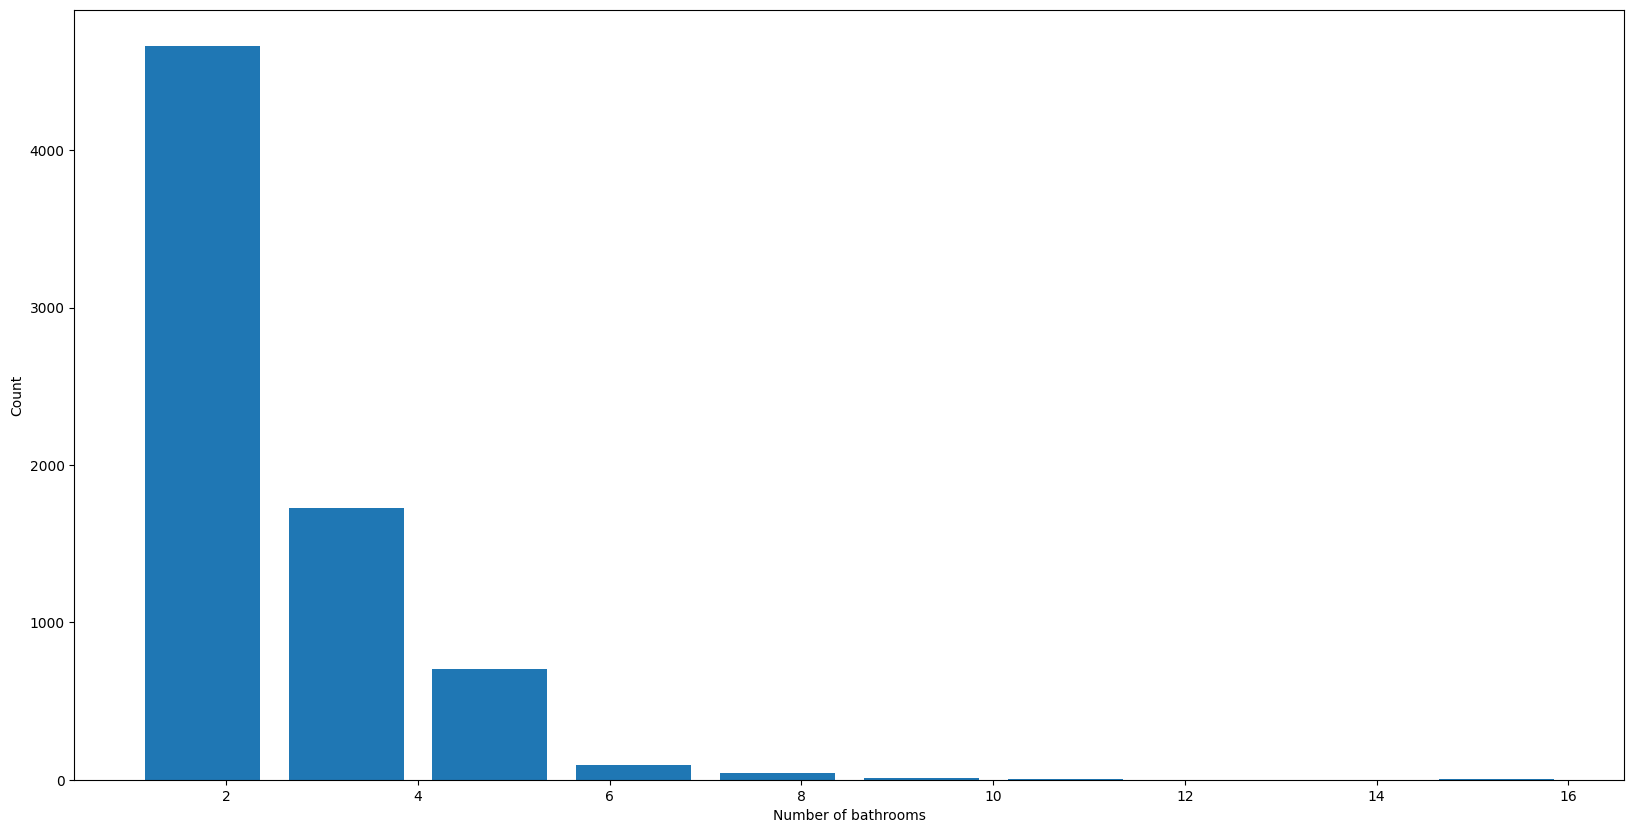

In [58]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [59]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5316,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8593,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
8800,other,14 BHK,1250.0,15.0,125.0,14,10000.000000
9584,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


In [60]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1669,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5275,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6784,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8447,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689
9597,other,6 Bedroom,1200.0,9.0,122.0,6,10166.666667


In [61]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape


(7174, 7)

<Axes: xlabel='bhk', ylabel='price_per_sqft'>

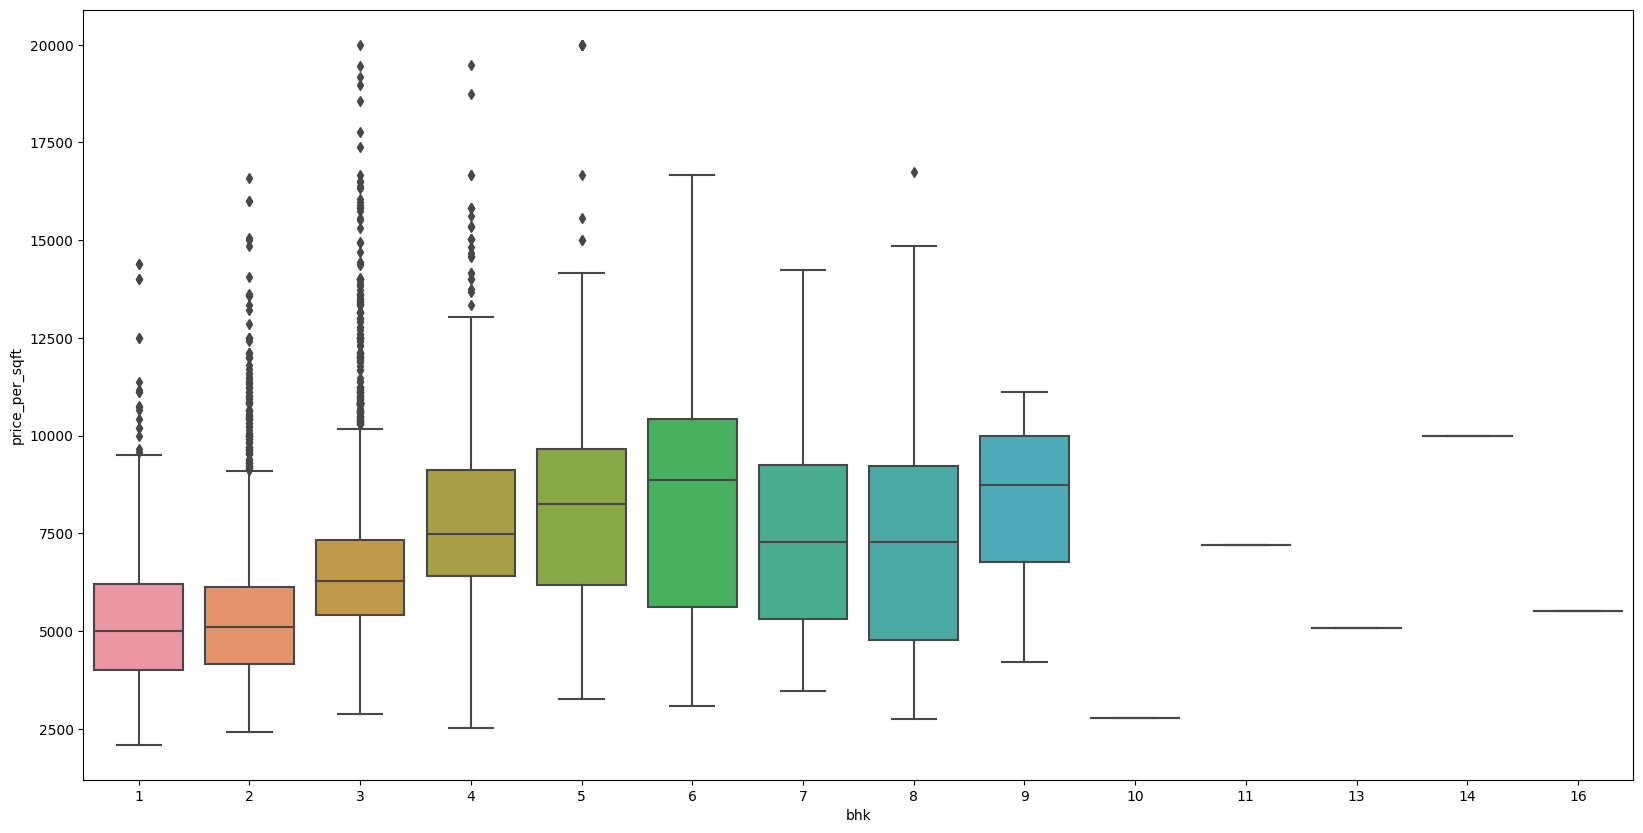

In [62]:
sns.boxplot( data = df9, x = 'bhk', y = 'price_per_sqft')

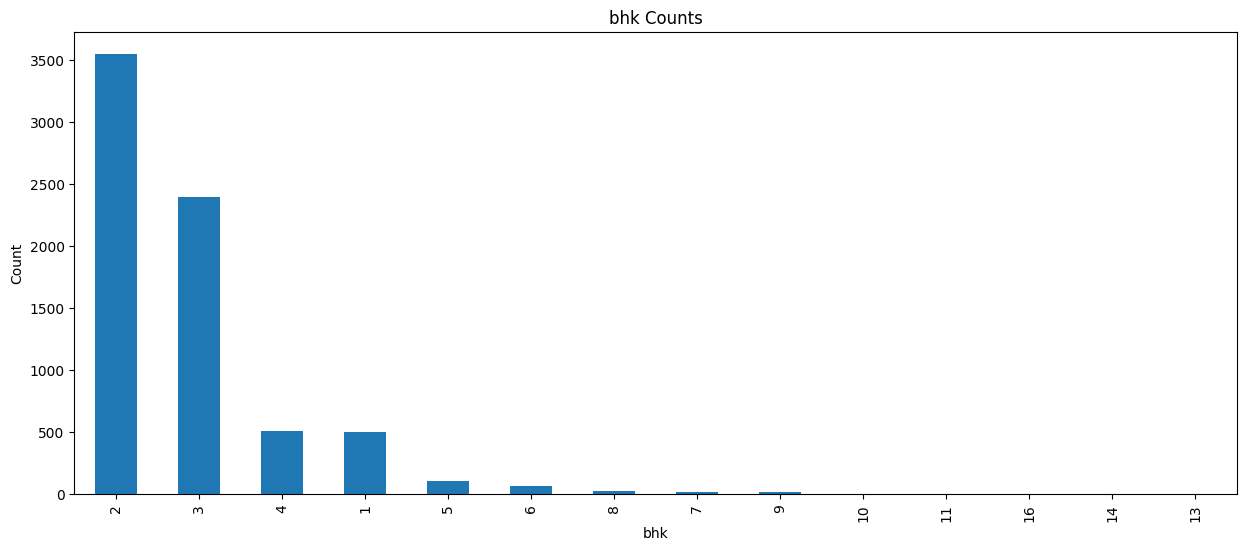

In [63]:
# Bar plot for location counts
plt.figure(figsize=(15, 6))
df9['bhk'].value_counts().plot(kind='bar')
plt.title('bhk Counts')
plt.xlabel('bhk')
plt.ylabel('Count')
plt.show()

<ipython-input-64-e99a6855f5fa>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df9.corr()


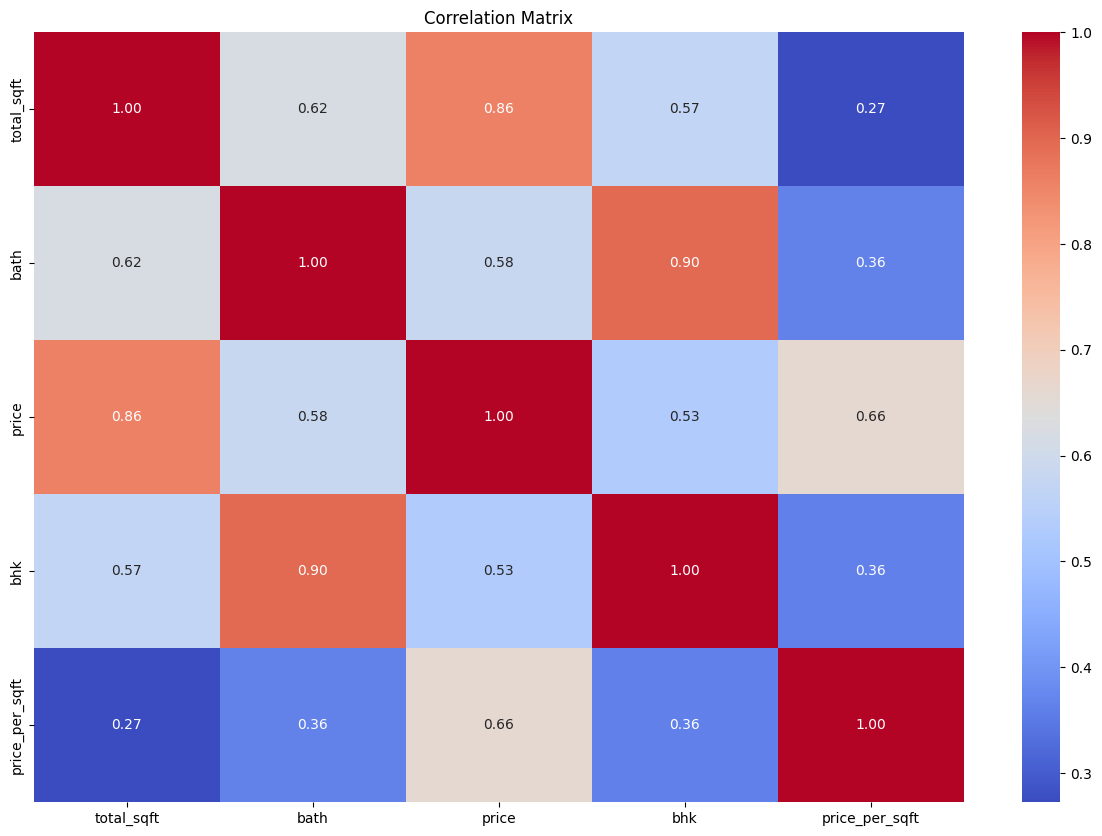

In [64]:
# Heatmap for correlation matrix
correlation_matrix = df9.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

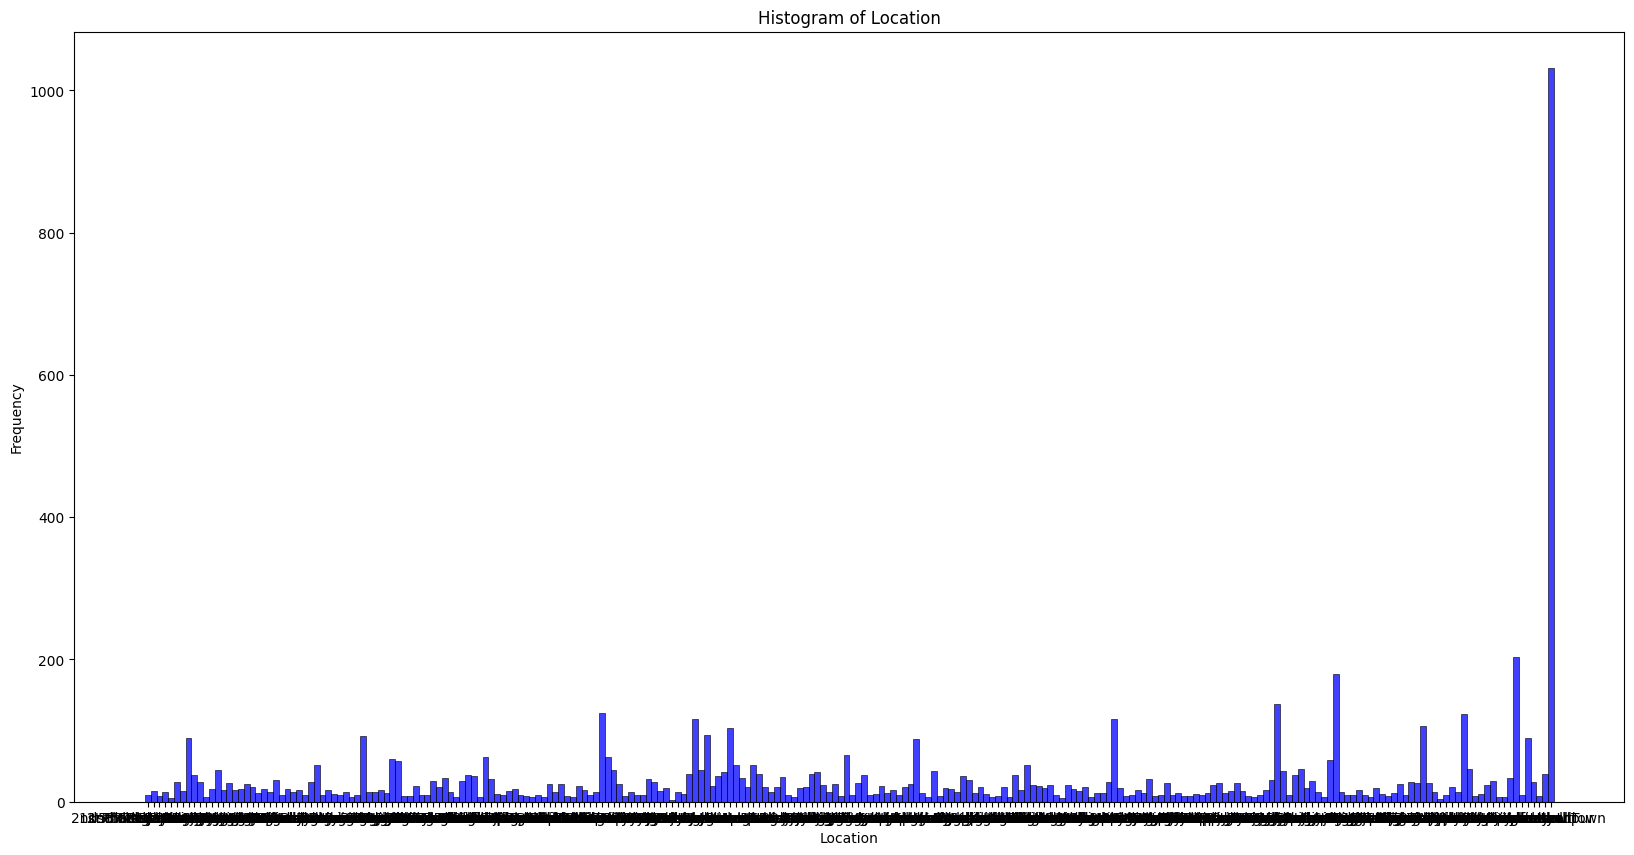

In [65]:
sns.histplot(df9['location'], bins=10, kde=False, color='blue', edgecolor='black')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.title('Histogram of Location')
plt.show()

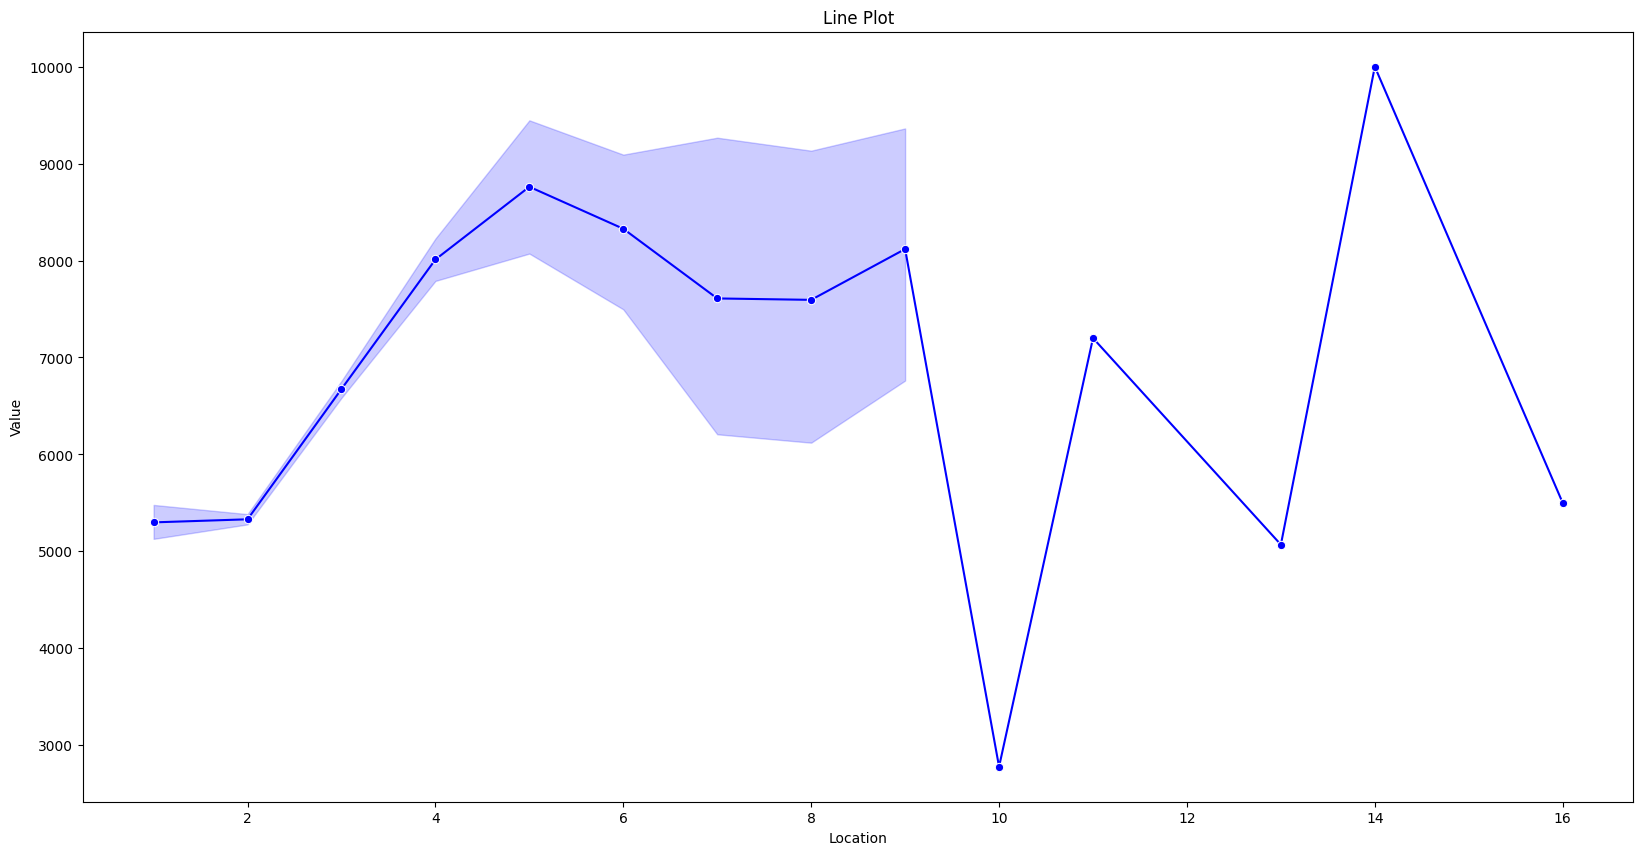

In [66]:
sns.lineplot(x = 'bhk', y = 'price_per_sqft', data=df9, marker='o', color='b')
plt.xlabel('Location')
plt.ylabel('Value')
plt.title('Line Plot')
plt.show()

In [67]:
df9.head(2)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491


In [68]:
df10 = df9.drop(['size'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,1200.0,6.0,125.0,6,10416.666667


In [69]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,price_per_sqft,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,15017.543860,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,11901.840491,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1200.0,6.0,125.0,6,10416.666667,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1875.0,2.0,235.0,3,12533.333333,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,930.0,4.0,85.0,7,9139.784946,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
df12 = df11.drop('location',axis='columns')
df12.head(2)

,total_sqft,bath,price,bhk,price_per_sqft,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,15017.543860,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,11901.840491,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
df12.shape

(7174, 246)

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

In [74]:
# Assuming X is your feature matrix, and y is the target variable 'price'
X = df12.drop(['price'], axis='columns')
X.head(3)

,total_sqft,bath,bhk,price_per_sqft,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,15017.543860,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,11901.840491,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.0,6.0,6,10416.666667,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
y = df12['price']
y.head(3)

0    428.0
1    194.0
2    125.0
Name: price, dtype: float64

In [76]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [77]:
# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)


LinearRegression()

In [82]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred

array([122.98866116,  84.17970608,  66.22668463, ...,  53.43079169,
        74.28722639,   3.34601582])

In [79]:
# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 16.212415818045574


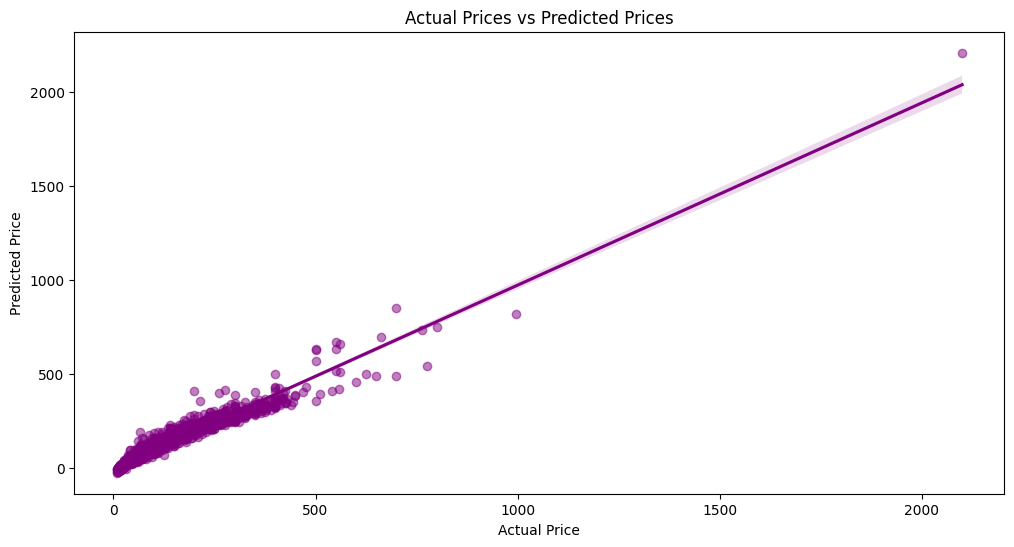

In [87]:
y_actual = df12['price'].values
y_predicted = model.predict(X)

# Create a DataFrame for better visualization
visualization_df = pd.DataFrame({'Actual Price': y_actual, 'Predicted Price': y_predicted})

# Scatter plot for actual vs predicted prices
plt.figure(figsize=(12, 6))
sns.regplot(x='Actual Price', y='Predicted Price', data=visualization_df, scatter_kws={'alpha': 0.5}, color='purple')
plt.title('Actual Prices vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

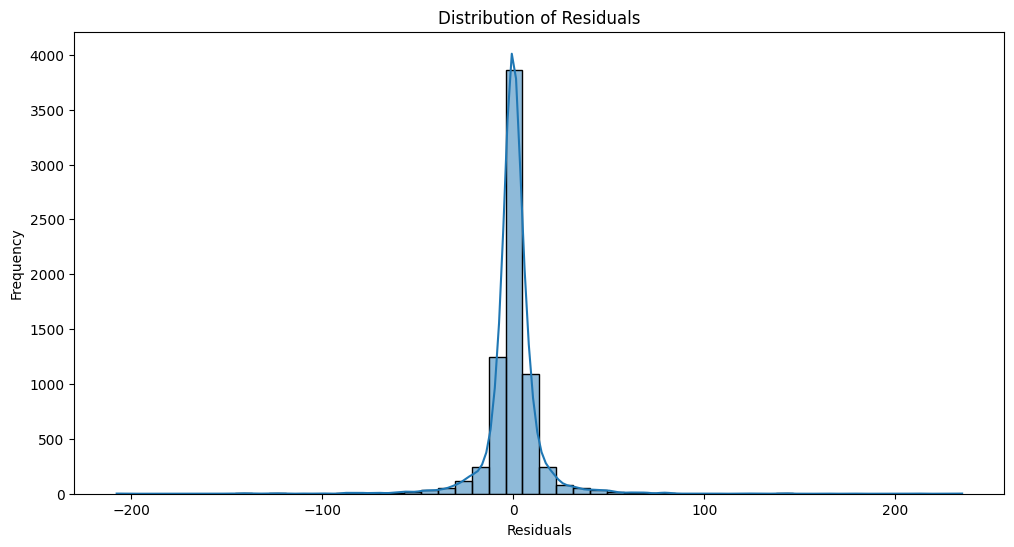

In [84]:
# Distribution plot for residuals
residuals = y_actual - y_predicted
plt.figure(figsize=(12, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

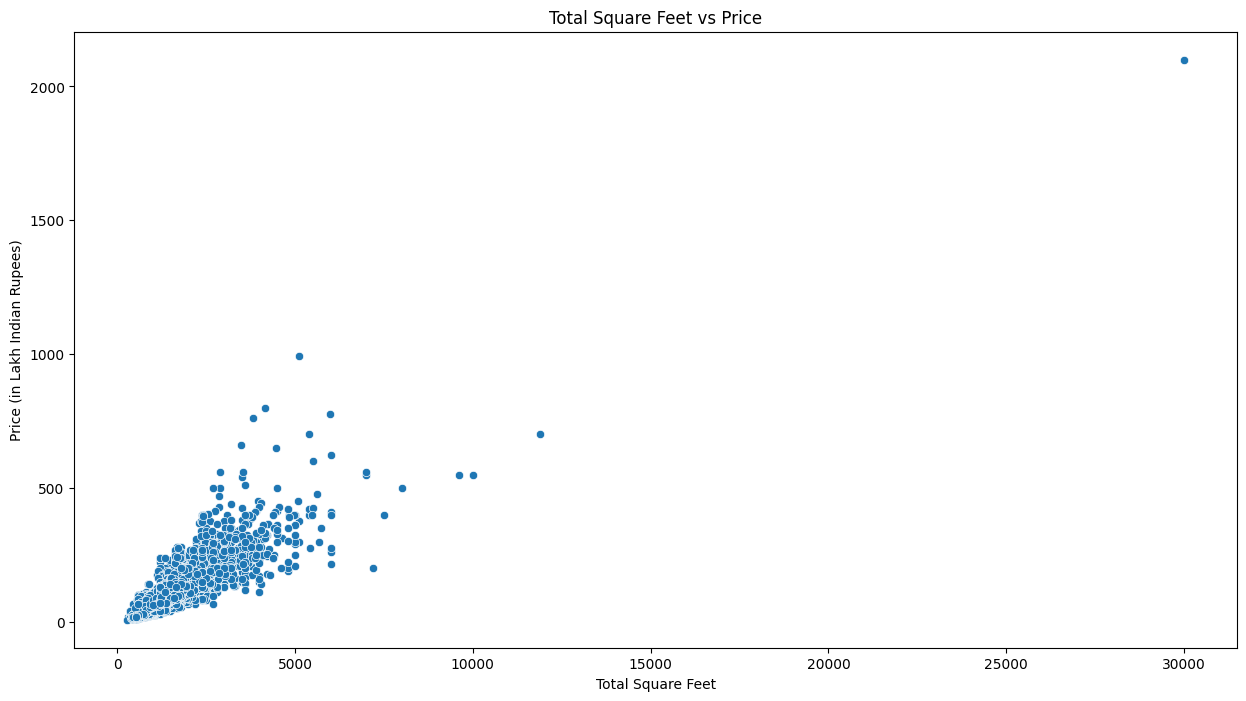

In [85]:
# Scatter plot for Total Square Feet vs Price
plt.figure(figsize=(15, 8))
sns.scatterplot(x='total_sqft', y='price', data=df12)
plt.title('Total Square Feet vs Price')
plt.xlabel('Total Square Feet')
plt.ylabel('Price (in Lakh Indian Rupees)')
plt.show()